# Project 2: Advance Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import pickle
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Camera calibration & distortion corrected image

In [2]:
def read_images(images_path):
    #enter '/*' after folder name to capture all images inside
    images = glob.glob(images_path)
    return images

def camera_calibration(images, img_size):
   
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)   
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # loop through the list of images and find all the corners in an image if there are any
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found > add into object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

     # Not needed cv2.drawChessboardCorners(img, (9,6), corners, ret)
     # not needed plt.imshow(img)
            
    #computing camera parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
  
    # Save the camera calibration result for later usage
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open("camera_cal/calibration1.p", "wb"))

    return mtx, dist
    
def undistort_image(img, mtx, dist):
    #undistorting an image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def image_show_before_after2(img, img_name, dst, after_img_name):
# Visualize two images side by side, write image names in '' 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title(img_name, fontsize=30)
    ax2.imshow(dst)
    ax2.set_title(after_img_name, fontsize=30)

def show_image(image): 
    plt.imshow(image)
    plt.show()

### 1.1. Unit Testing: undistortion on an image

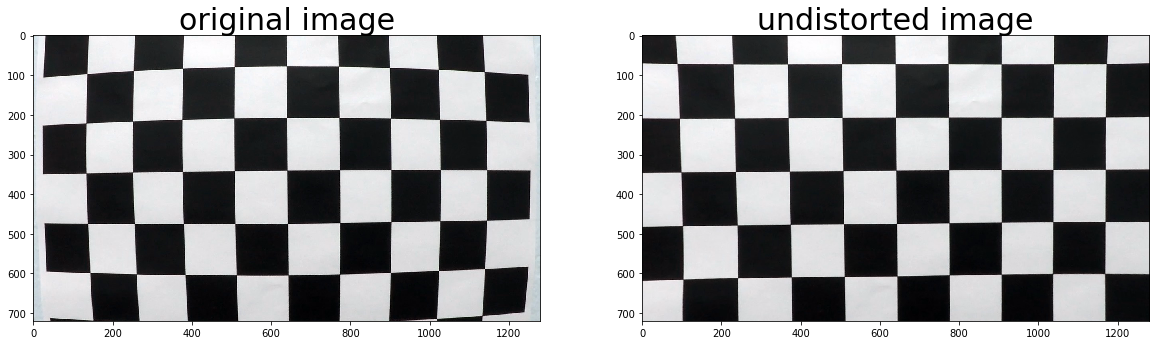

In [3]:
# read in images
images = read_images('camera_cal/*.jpg')

#check calibration and undistortion on an image
cal_img = cv2.imread('camera_cal/calibration1.jpg')
# use in addition to the line above when needed according to the image results
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (cal_img.shape[1], cal_img.shape[0])

mtx, dist = camera_calibration(images, img_size)
dst= undistort_image(cal_img, mtx, dist)
image_show_before_after2(cal_img, 'original image', dst, 'undistorted image')

### 1.2. Unit Test: Undistorting Test Images

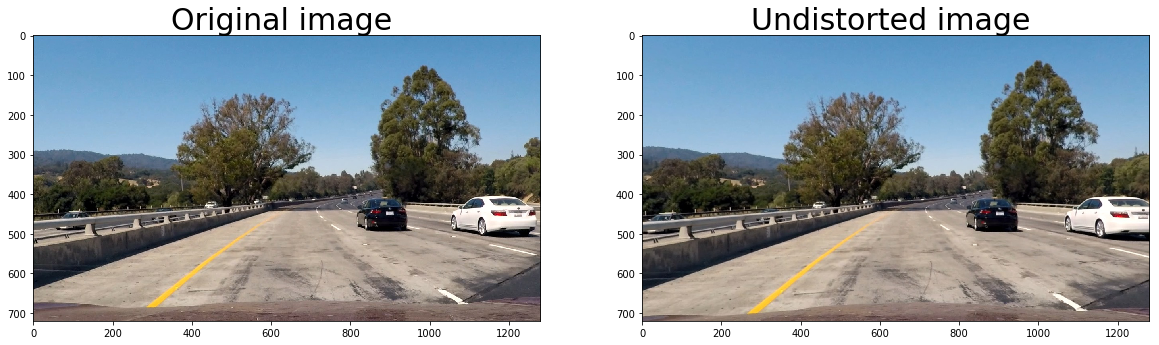

In [4]:
orj_image = cv2.imread('test_images/test1.jpg')
undistorted_image = undistort_image(orj_image, mtx, dist)
cv2.imwrite("output_images/ud_testimage1" + ".jpg", undistorted_image)

orj_image = mpimg.imread('test_images/test1.jpg')
undistorted_image = undistort_image(orj_image, mtx, dist)
image_show_before_after2(orj_image, 'Original image ', undistorted_image, 'Undistorted image ') 

## 2. Binary Image

In [5]:
def binary_image(img, h_thresh=(150, 255), l_thresh=(20, 255),s_thresh=(100, 255), sx_thresh=(12, 255), sy_thresh=(25, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel y
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate horizontal lines
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, sybinary, h_binary, l_binary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((h_binary == 1) & (s_binary == 1) & (l_binary == 1)) | ((sxbinary == 1) & (sybinary == 1))] = 1
    return combined_binary

## 2.1  Unit Test : Binary image

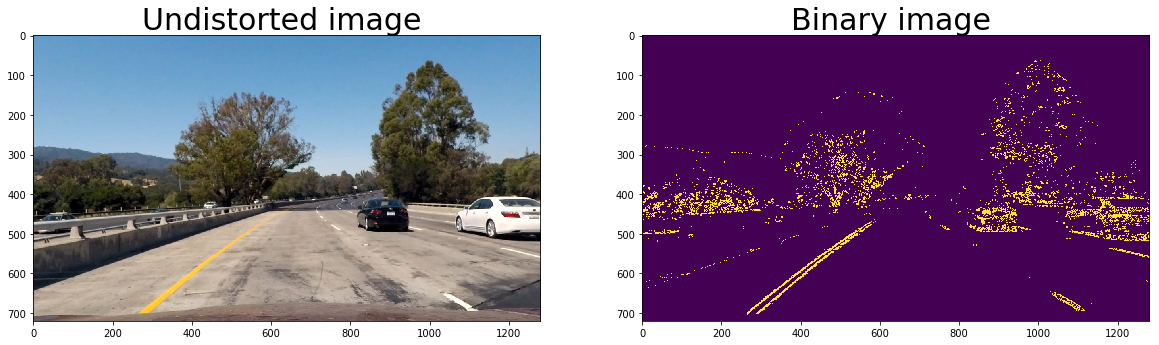

In [6]:
und_image = mpimg.imread('output_images/ud_testimage1.jpg')
binary = binary_image(und_image)
image_show_before_after2(und_image, 'Undistorted image ', binary, 'Binary image ') 

In [7]:
'''
for i, filename in enumerate(test_images):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary = binary_image(img)
    cv2.imwrite("output_images/ud_" + str(i+1) + ".jpg", binary)
    image_show_before_after2(img, 'Original image '+str(i+1), binary, 'binary image '+str(i+1))
'''

'\nfor i, filename in enumerate(test_images):\n    img = cv2.imread(filename)\n    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n    binary = binary_image(img)\n    cv2.imwrite("output_images/ud_" + str(i+1) + ".jpg", binary)\n    image_show_before_after2(img, \'Original image \'+str(i+1), binary, \'binary image \'+str(i+1))\n'

## 3. Perspective Transform

In [8]:
def perspective_transform(img, src1,src2,src3,src4, offset=0):
    #just enter source points and offset, adjust iteratively
    #src1-left top, src2-right top, src3-left bottom, src4-right bottom points
    h = img.shape[0]
    w = img.shape[1]
    img_size = (w, h)

    src = np.float32([src1,src2,src3,src4])
    
    dst = np.float32([[offset, 0],
                      [w-offset, 0],
                      [offset, h],
                      [w-offset, h]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

## 3.1 Unit Test: perspective transform

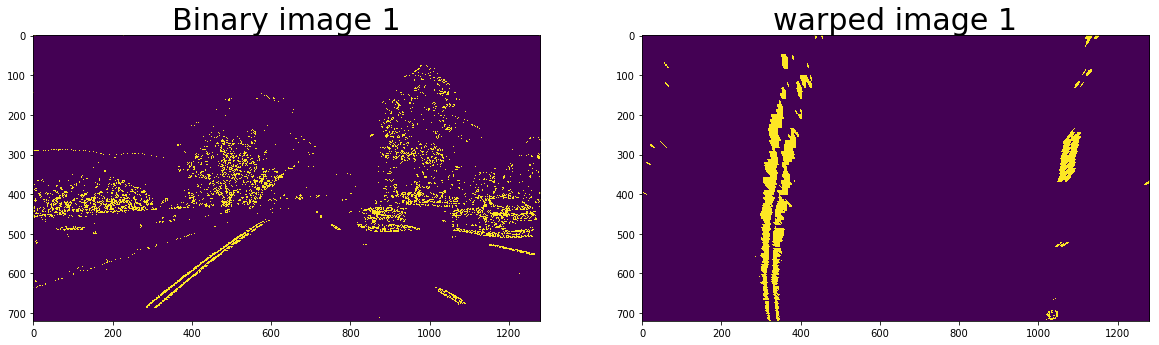

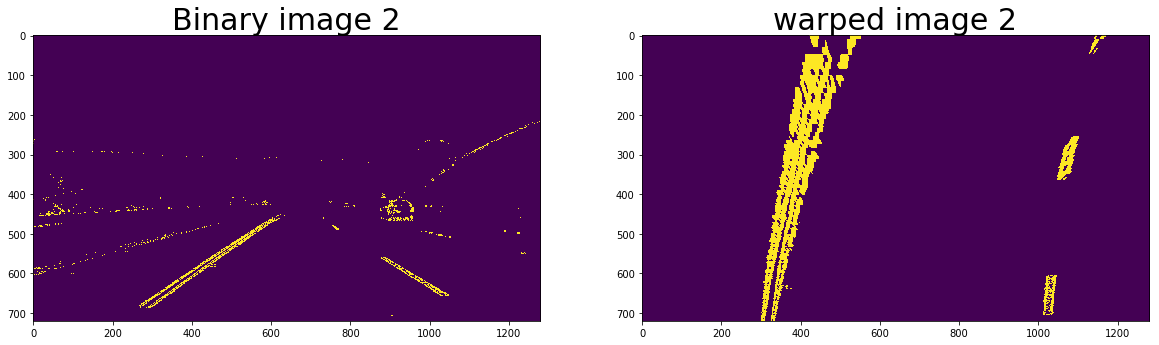

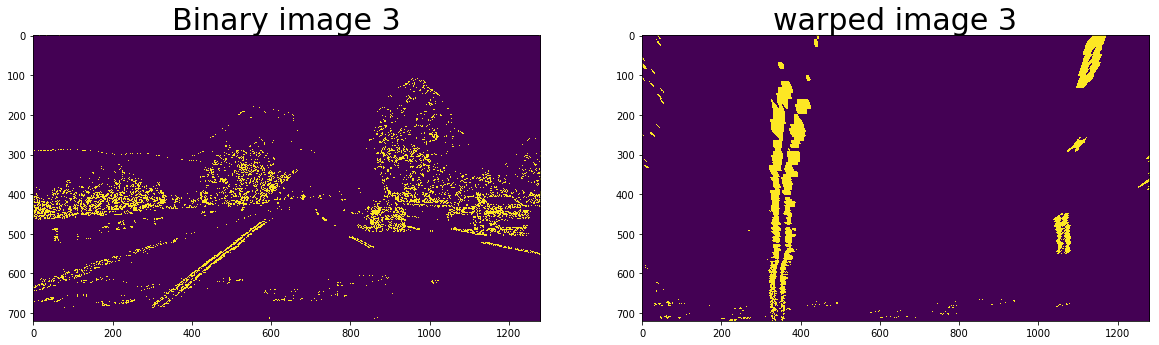

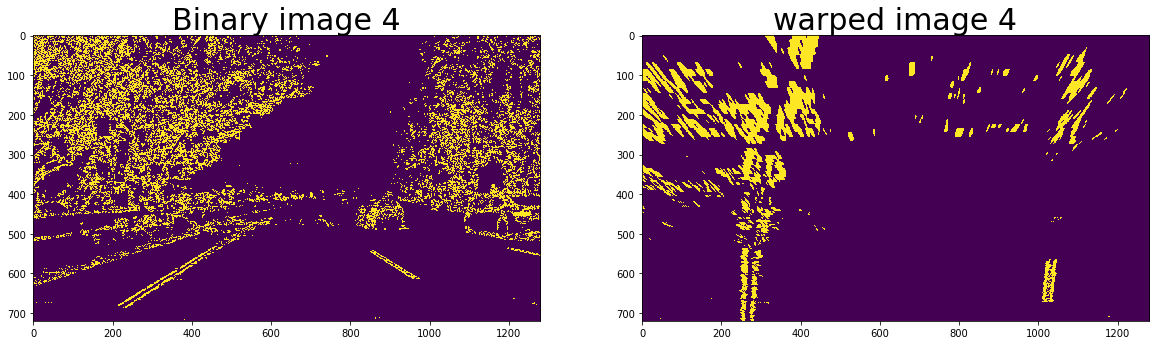

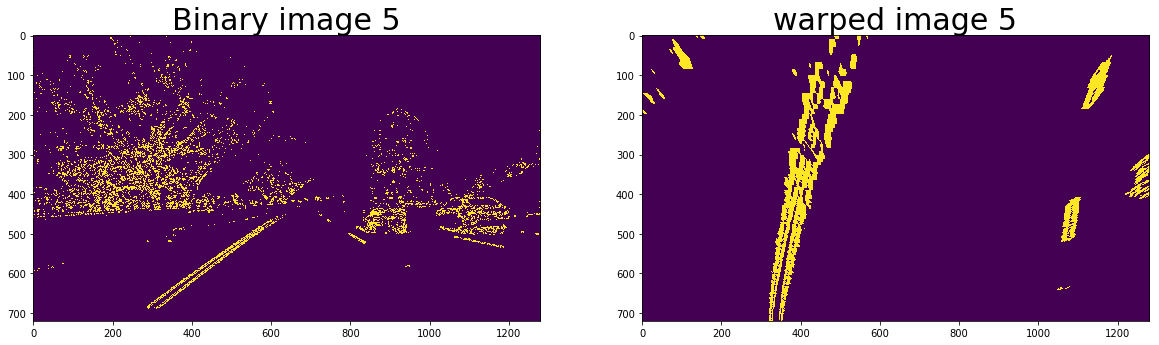

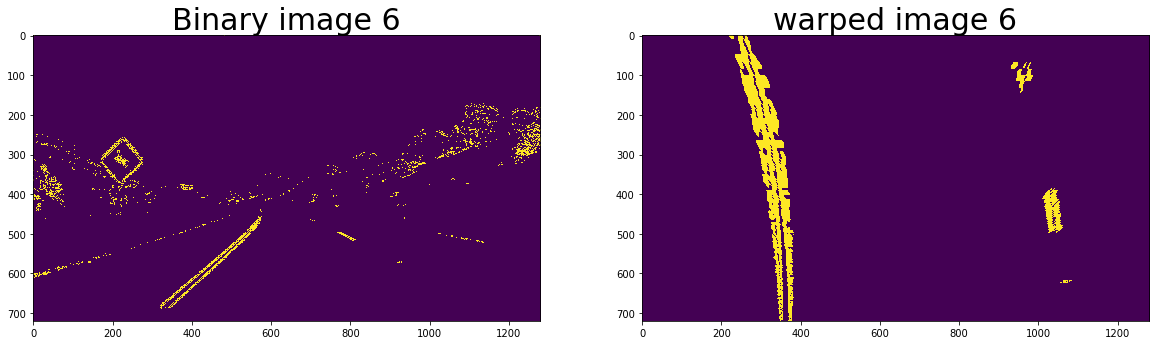

In [9]:
test_images = read_images('test_images/test*.jpg')
for i, filename in enumerate(test_images):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary = binary_image(img)
    cv2.imwrite("output_images/binary_testimage" + str(i+1) + ".jpg", binary)
    warped, Minv = perspective_transform(binary,[580,460],[700,460],[260,685],[1040,685], offset=300)
    image_show_before_after2(binary, 'Binary image '+str(i+1), warped, 'warped image '+str(i+1))
   

## 4. Detecting lane-lines and polynomial fitting

In [10]:
def find_lane_pixels(binary_warped):
    #takes a binary_warped image, takes the lower half of it for the sum of histogram values
    #uses Hyperparameters of nwindows(window quantity), margin (windows +/- margin), 
    #minpix is the minimum amount of pixels that must be to shift the window in the next iteration
    nwindows=12
    margin=75
    minpix=50
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        #Below, 4 boundaries of the window
        win_xleft_low = np.int(leftx_current - margin)
        win_xleft_high = np.int(leftx_current + margin)
        win_xright_low = np.int(rightx_current - margin)
        win_xright_high = np.int(rightx_current + margin)
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                              (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                              (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #nonzero pixels in x and y inside the window area
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & 
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xright_low) & 
                          (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
         ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    #return out_img, left_fit, right_fit, ploty, leftx, lefty, rightx, righty
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty


## Unit Test: detecting lane lines

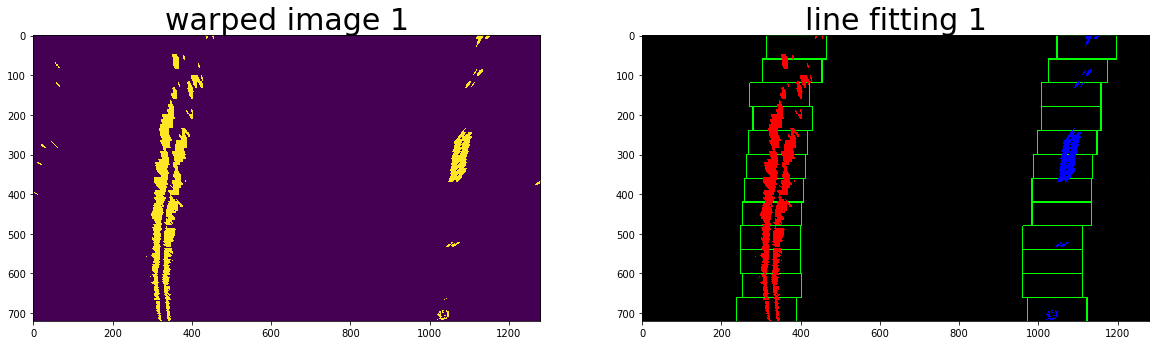

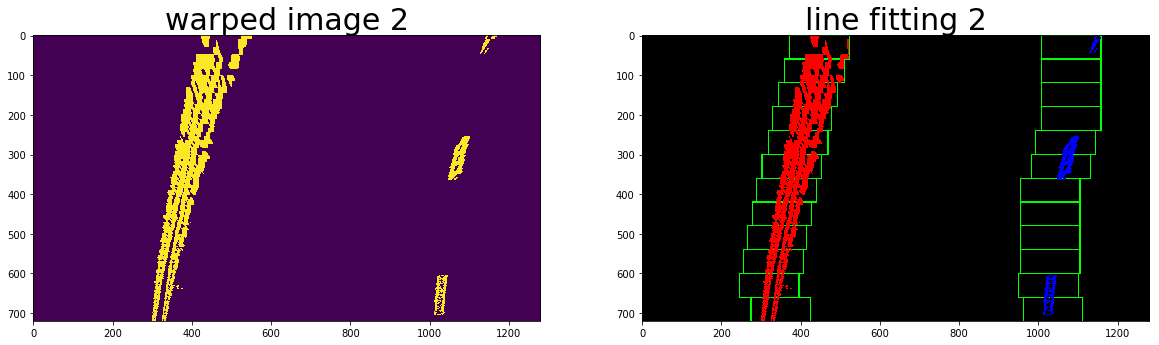

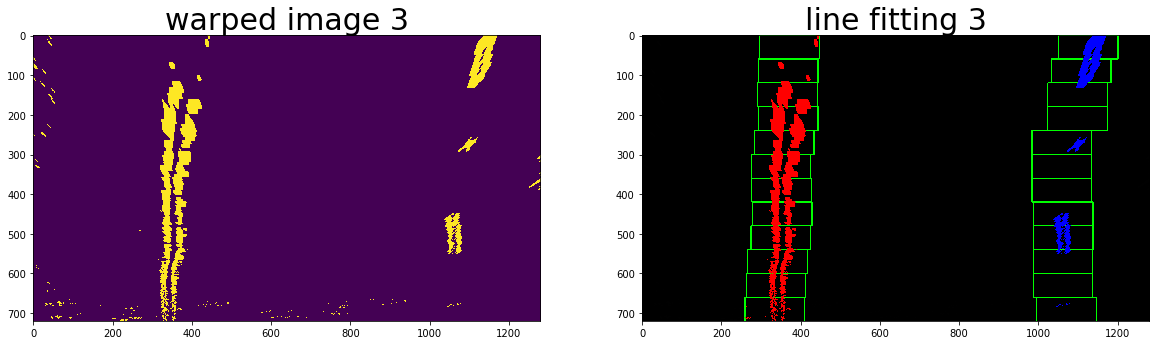

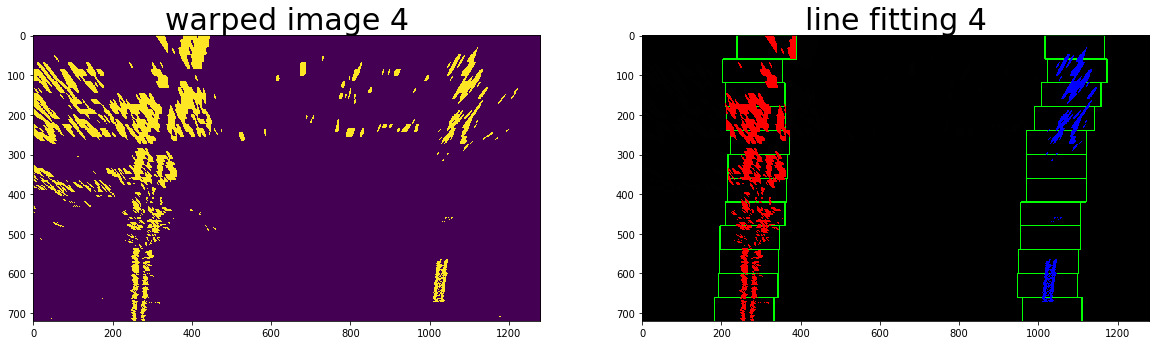

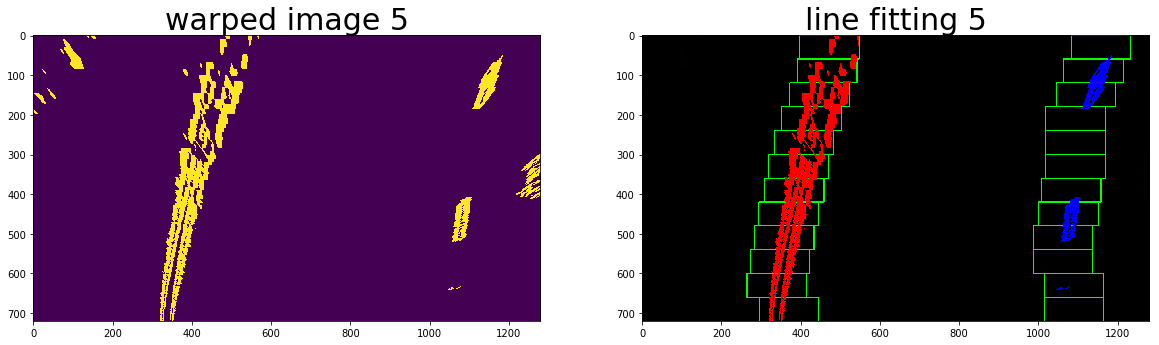

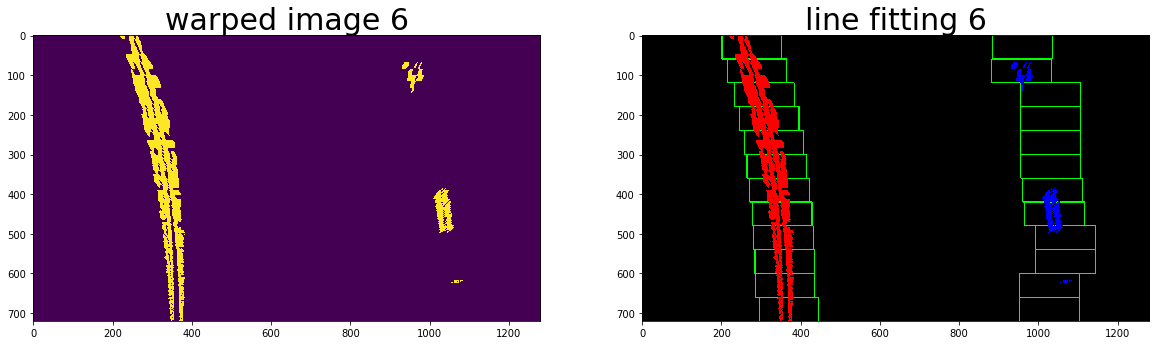

In [11]:

for i, filename in enumerate(test_images):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary = binary_image(img)
    warped, Minv = perspective_transform(binary,[580,460],[700,460],[260,685],[1040,685], offset=300)
    out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped)
    cv2.imwrite("output_images/lane_" + str(i+1) + ".jpg", out_img)
    image_show_before_after2(warped, 'warped image '+str(i+1), out_img, 'line fitting '+str(i+1))
  

### 4.2 Skipping windows and searching around previous detected line

In [12]:
# Polynomial fit values from the previous frame

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 75

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Set the area of search based on activated x-values ###
    # within the +/- margin of our polynomial function ###
    # Fit new polynomials
    #left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)

    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #filling area between lanes
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line, right_line))
 
    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255,0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    return result

## 4.3 Unit Test: search around poly

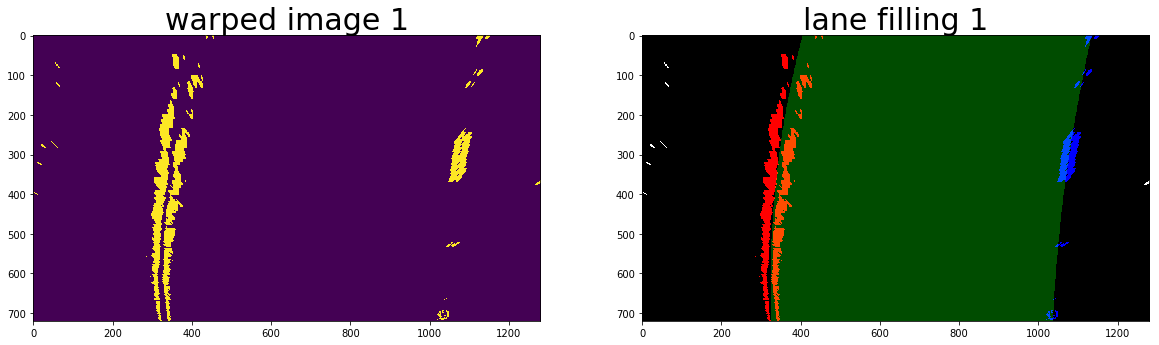

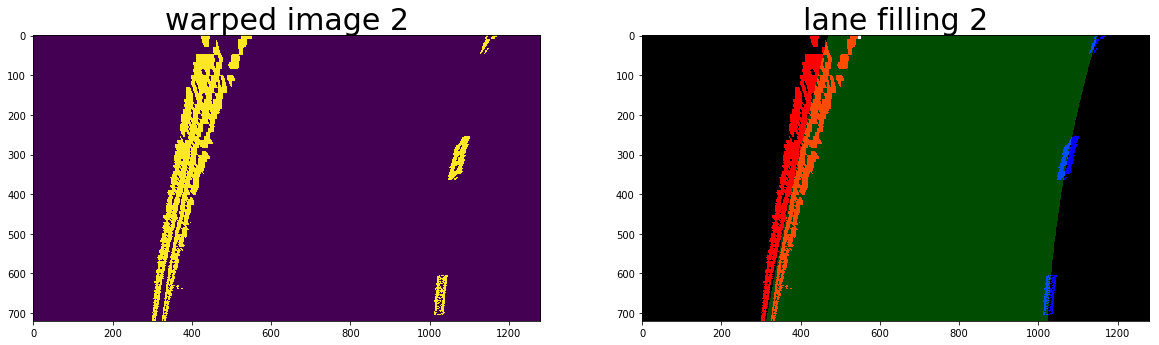

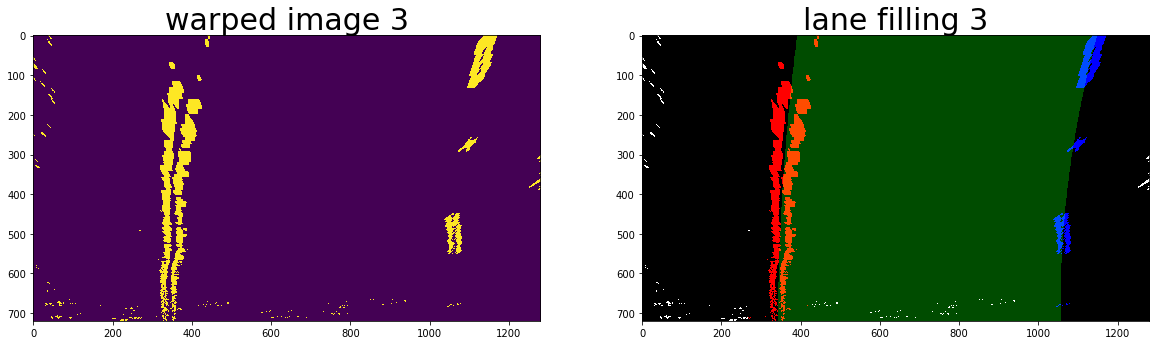

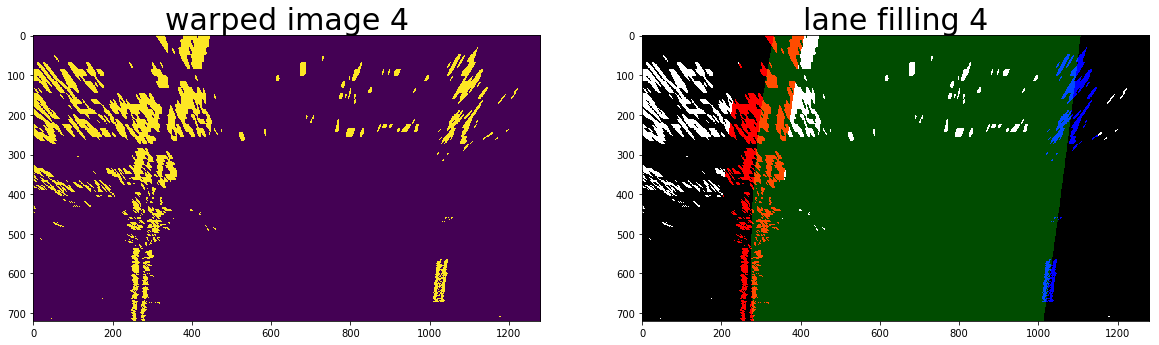

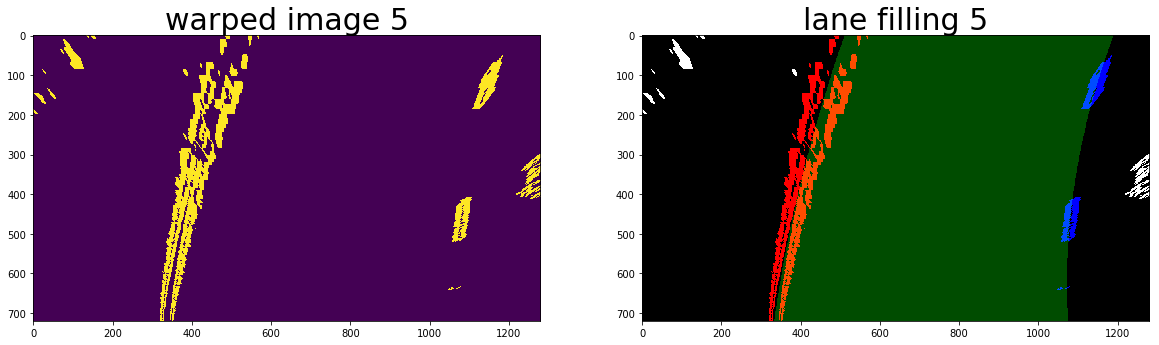

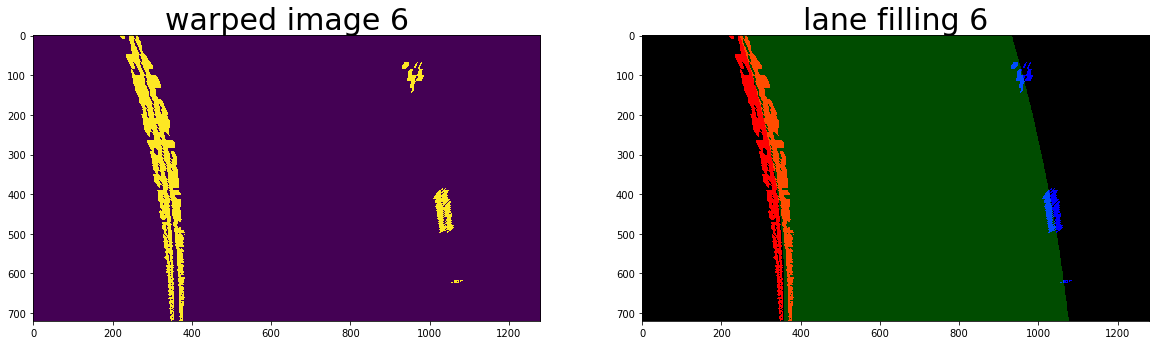

In [13]:

for i, filename in enumerate(test_images):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    binary = binary_image(img)
    warped, Minv = perspective_transform(binary,[580,460],[700,460],[260,685],[1040,685], offset=300)
    search_around = search_around_poly(warped)
    image_show_before_after2(warped, 'warped image '+str(i+1), search_around, 'lane filling '+str(i+1))

## 5. Determining curvature of the lane & vehicle position

In [14]:
 def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #calculation of R_curve (radius of curvature)
    A_left = left_fit[0]
    B_left = left_fit[1]
    A_right = right_fit[0]
    B_right = right_fit[1]
    left_curverad = ((1+(2*A_left * y_eval + B_left)**2)**(3/2))/ (np.abs(2*A_left))
    right_curverad = ((1+(2*A_right * y_eval + B_right)**2)**(3/2))/ (np.abs(2*A_right)) 
    
    return left_curverad, right_curverad

### 5.1. Measuring real curvature in meters

In [15]:
def measure_curvature_real(binary_image):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_image)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    curve_h = binary_image.shape[0]
    ploty = np.linspace(0, curve_h-1, curve_h)
    y_eval = np.max(ploty)
    
   
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curverad = (left_curverad + right_curverad) / 2
    
    return left_curverad, right_curverad, round(avg_curverad)

### 5.2. Measuring Vehicle Offset in the lane

In [16]:
def vehicle_offset(binary_warped):
    #vehicle offset from the lane can be determined by
    #comparing lane center to the image center. 
    #if there is a difference between 'image center' vs 'lane center'
    #vehicle will have an offset by 'lane center' - 'image center' 
    #(positive means vehicle shifted to left)
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
    lane_center = (left_fitx[-1] + right_fitx[-1])/2 
    
    image_center = binary_warped.shape[1]/2 #1280 --> img.shape[1]
    
    return (image_center - lane_center) * xm_per_pix    


# ***

# 6. Combination of steps

 avg_curverad= 817.0 m

 vehicle offset -0.387500586027 m


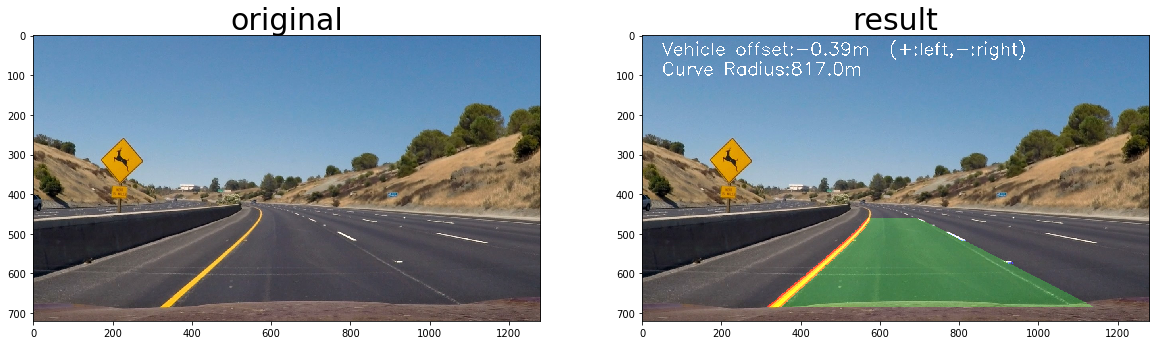

In [17]:
test_image = mpimg.imread("test_images/test2.jpg")
#binary image
undistorted = undistort_image(test_image, mtx, dist)
binary_img = binary_image(undistorted, h_thresh=(15, 100), 
                          l_thresh=(10, 220),s_thresh=(90, 255), 
                          sx_thresh=(12, 255), sy_thresh=(25, 255))

#image_show_before_after2(test_image, 'original image', binary_img, 'combined binary image')

#just enter source points and offset, adjust iteratively
binary_warped, Minv = perspective_transform(binary_img,
                                      [580,460],[700,460],[260,685],[1040,685],offset=300)
#image_show_before_after2(test_image, 'original image', binary_warped, 'warped image')

#getting polynomial fit and left-right lane fitting parameters
#out_img, left_fit, right_fit, ploty, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
                                              
#print('left_fit =', left_fit,'\n', 'right_fit =', right_fit)
#plt.imshow(out_img)

# Run image through the pipeline
result = search_around_poly(binary_warped)

# View output on warped image ***just for progressive design, skip it at the final version***
#plt.imshow(result)

#drawing the area on the image
unwarped_result = cv2.warpPerspective(result, Minv, 
                                     (test_image.shape[1], test_image.shape[0]), 
                                     flags=cv2.INTER_LINEAR)
result1 = cv2.addWeighted(unwarped_result, 0.8, test_image, 1., 0.)

# Calculate the radius of curve and vehicle offset from lane center
left_curverad, right_curverad, avg_curverad = measure_curvature_real(binary_warped)
offset = vehicle_offset(binary_warped)
print(' avg_curverad=', avg_curverad, 'm\n\n','vehicle offset', offset , 'm' )

#writing offset and radius on the final image

cv2.putText(result1,'Curve Radius:' + str(round(avg_curverad)) + 'm', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
cv2.putText(result1,'Vehicle offset:' + str(round(offset, 2)) + 'm  (+:left,-:right)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)

#showing two images side by side
image_show_before_after2(test_image, 'original', result1, 'result')

In [18]:
def pipeline(image):
    #binary image
    undistorted = undistort_image(image, mtx, dist)
    binary_img = binary_image(undistorted, h_thresh=(15, 100), 
                              l_thresh=(10, 220),s_thresh=(90, 255), 
                              sx_thresh=(12, 255), sy_thresh=(25, 255))

    #image_show_before_after2(test_image, 'original image', binary_img, 'combined binary image')

    #just enter source points and offset, adjust iteratively
    binary_warped, Minv = perspective_transform(binary_img,
                                          [580,460],[700,460],[260,685],[1040,685],offset=300)
    #image_show_before_after2(test_image, 'original image', binary_warped, 'warped image')

    #getting polynomial fit and left-right lane fitting parameters
    #out_img, left_fit, right_fit, ploty, leftx, lefty, rightx, righty = fit_polynomial(binary_warped)
    out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)

    #print('left_fit =', left_fit,'\n', 'right_fit =', right_fit)
    #plt.imshow(out_img)

    # Run image through the pipeline
    result = search_around_poly(binary_warped)

    # View output on warped image ***just for progressive design, skip it at the final version***
    #plt.imshow(result)

    #drawing the area on the image
    unwarped_result = cv2.warpPerspective(result, Minv, 
                                         (image.shape[1], image.shape[0]), 
                                         flags=cv2.INTER_LINEAR)
    result1 = cv2.addWeighted(unwarped_result, 0.8, image, 1., 0.)

    # Calculate the radius of curve and vehicle offset from lane center
    left_curverad, right_curverad, avg_curverad = measure_curvature_real(binary_warped)
    offset = vehicle_offset(binary_warped)
    #print(' avg_curverad=', avg_curverad, 'm\n\n','vehicle offset', offset , 'm' )

    #writing offset and radius on the final image

    cv2.putText(result1,'Curve Radius:' + str(round(avg_curverad)) + 'm', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(result1,'Vehicle offset:' + str(round(offset, 2)) + 'm  (+:left,-:right)', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    
    return result1

## 6.1 Testing the pipeline

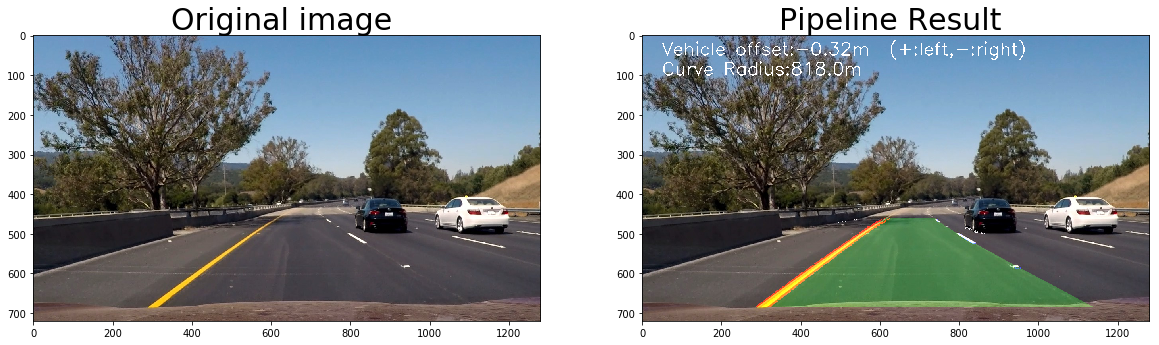

In [19]:
my_image = cv2.imread("test_images/test6.jpg")
pipeline_result = pipeline(my_image)
cv2.imwrite("output_images/pipeline_1" + ".jpg", pipeline_result)

orj_image = mpimg.imread("test_images/test6.jpg")
pipeline_result = pipeline(orj_image)
image_show_before_after2(orj_image, 'Original image ', pipeline_result, 'Pipeline Result ') 

In [20]:
'''
for i, filename in enumerate(test_images):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_pipeline = pipeline(img)
        image_show_before_after2(test_pipeline, 'pipeline result '+str(i+1), img, 'orjinal '+str(i+1)),
'''

"\nfor i, filename in enumerate(test_images):\n        img = cv2.imread(filename)\n        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n        test_pipeline = pipeline(img)\n        image_show_before_after2(test_pipeline, 'pipeline result '+str(i+1), img, 'orjinal '+str(i+1)),\n"

## 7. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video = 'output_videos/pipeline_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video, audio=False)

[MoviePy] >>>> Building video output_videos/pipeline_project_video.mp4
[MoviePy] Writing video output_videos/pipeline_project_video.mp4


100%|█████████▉| 1260/1261 [06:08<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/pipeline_project_video.mp4 

CPU times: user 3min 58s, sys: 5.99 s, total: 4min 4s
Wall time: 6min 11s


## 8. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?


# ************

In [22]:
#to zip all files from the jupyter notebook - preperatıon for download
!tar chvfz CarND_AdvanceLaneFinding.tar.gz *


CarND_AdvanceLaneFinding.ipynb
LICENSE
README.md
Writeup_images/
Writeup_images/perspective_transform.JPG
Writeup_images/fit_polynomial.JPG
Writeup_images/binary_result.JPG
Writeup_images/camera_undistort.JPG
Writeup_images/pipeline.JPG
Writeup_images/search_around_poly.JPG
Writeup_images/ud_testimage1.jpg
camera_cal/
camera_cal/calibration3.jpg
camera_cal/calibration9.jpg
camera_cal/calibration12.jpg
camera_cal/calibration20.jpg
camera_cal/calibration16.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration4.jpg
camera_cal/calibration7.jpg
camera_cal/calibration2.jpg
camera_cal/calibration.p
camera_cal/calibration11.jpg
camera_cal/calibration17.jpg
camera_cal/calibration1.jpg
camera_cal/calibration19.jpg
camera_cal/calibration10.jpg
camera_cal/calibration5.jpg
camera_cal/calibration5.p
camera_cal/calibration15.jpg
camera_cal/calibration9.p
camera_cal/calibration8.jpg
camera_cal/calibration1.p
camera_cal/calibration6.jpg
camera_cal/calibration18.jpg
challe